<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em></center>

# MNIST mit Multi-Layer Perceptron

In dieser Lektion werden wir ein Multi Layer Perceptron Modell erstellen und versuchen damit handgeschriebenen Zahlen zu klassifizieren. Das ist ein sehr verbreitetes Einsteigerproblem für Tensorflow.

Denkt daran, dass eine einzige Lektion niemals ausreichen wird, um Deep Learning und/oder Tensorflow in seiner Komlexität abzudecken!

## Die Daten laden

Wir werden die berühmten MNIST Daten über [handgeschriebenen Zahlen](http://yann.lecun.com/exdb/mnist/) verwenden.

Die Bilder die wir verwenden werden sind schwarz-weiß Bilder der größe 28 x 28, d.h. 784 Pixel insgesamt. Unsere Features werden die Pixelwerte für jeden Pixel sein. Entweder ist der Pixel "weiß" (also eine 0 in den Daten) oder er hat einen Pixelwert.

Wir werden versuchen korrekt vorherzusagen, welche Nummer geschrieben steht. Dazu verwenden wir lediglich die Bilddaten in Form unseres Arrays. Diese Art von Problem (Image Recognition oder auf Deutsch: Bilderkennung) ist ein tolle Use Case für Deep Learning Methoden!

Die Daten sind für Deep Learning das, was der Iris Datensatz für typische Machine Learning Algorithmen ist.

# Import von Bibliotheken in Python.

In diesem Code werden die Python-Bibliotheken TensorFlow, NumPy, Logging, Time, Matplotlib und Unittest importiert.

In [1]:
import tensorflow as tf
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import unittest
import numpy as np

Dieser Code importiert verschiedene Python-Bibliotheken, lädt den MNIST-Datensatz, normalisiert die Daten, teilt sie in Trainings- und Testdaten auf und konvertiert die Trainingsdaten in das gewünschte Datenformat für spätere Verwendung.

In [2]:
from functools import wraps
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Laden Sie die Daten herunter
def download():
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype('float64')
    y = mnist.target.astype('int')  # Konvertiere die Labels in Ganzzahlen
    return (X, y)

# Normalisieren der Daten
class Normalize(object):
    def normalize(self, X_train, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return (X_train, X_test)
    
    def inverse(self, X_train, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_test = self.scaler.inverse_transform(X_test)
        return (X_train, X_test)

# Aufteilen der Daten
def split(X, y, splitVerhältnis):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    return (X_train, y_train, X_test, y_test)

# Importieren Sie MNIST-Daten
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
(X, y) = download()

normalizer = Normalize()
X_train, X_test = normalizer.normalize(X, X)

splitRatio = 0.8  # Ändern Sie den Split-Verhältnis nach Bedarf
x_train, y_train, x_test, y_test = split(X_train, y, splitRatio)

# Stelle sicher, dass die Daten korrekt geladen wurden
assert x_train.shape == (int(0.8 * len(X)), X.shape[1])
assert x_test.shape == (int(0.2 * len(X)), X.shape[1])
assert y_train.shape == (int(0.8 * len(X)),)
assert y_test.shape == (int(0.2 * len(X)),)  # Überprüfung der Form der Labels

# Konvertiere die Trainingsdaten in float32
x_train = x_train.astype('float32')
y_train = y_train.astype('int')

C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Definieren der my_logger und my_timer Funktion

In [3]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

In [4]:
def my_timer(orig_func):
    import time

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

In diesem Code wird eine Python-Klasse mit dem Namen "TheAlgorithm" definiert, die verschiedene Methoden wie den Konstruktor __init__, die Methode fit und die Methode predict enthält, wobei die Dekoratoren @my_logger und @my_timer verwendet werden, um die Ausführung dieser Methoden zu protokollieren und die Zeitmessung durchzuführen.

In [5]:
class TheAlgorithm(object):
    @my_logger
    @my_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @my_logger
    @my_timer
    def fit(self):
        x_train, y_train, x_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test

        normalizer = Normalize()  # Use the correct class name here
        x_train, x_test = normalizer.normalize(x_train, x_test)

        train_samples = x_train.shape[0]

        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight='balanced',
        )

        self.classifier.fit(x_train, y_train)
        self.train_predictions = self.classifier.predict(x_train)
        self.train_accuracy = np.mean(self.train_predictions.ravel() == y_train.ravel()) * 100
        self.train_confusion_matrix = confusion_matrix(y_train, self.train_predictions)
        return self.train_accuracy

    @my_logger
    @my_timer
    def predict(self):
        x_test = self.X_test  # Test data doesn't need to be normalized again

        self.test_predictions = self.classifier.predict(x_test)
        self.test_accuracy = np.mean(self.test_predictions.ravel() == self.y_test.ravel()) * 100
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_predictions)
        self.report = classification_report(self.y_test, self.test_predictions)
        print("Classification Report for the classifier:\n%s\n" % (self.report))

        return self.test_accuracy


## Daten Format

Die Daten sind im Vektor Format gespeichert, obwohl die Originaldaten eine 2-dimensionale Matrix waren, die angab, wie viele Pigmente sich an welcher Position befinden. Untersuchen wir das genauer:

In [6]:
type(mnist)

module

In [7]:
type(x_train)
type(y_train)

pandas.core.series.Series

In [8]:
x_train[2].shape

(784,)

In [9]:
sample = x_train[2].reshape(28, 28)

In [10]:
%matplotlib inline

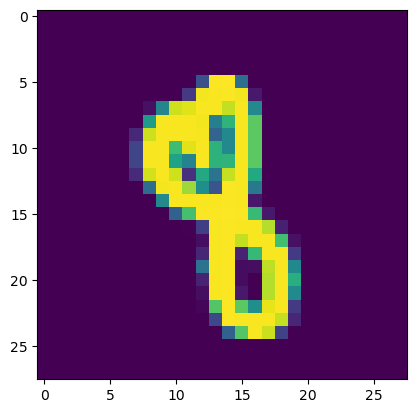

In [11]:
plt.imshow(sample)

## Parameter

Wir werden 4 Parameter definieren müssen. Es ist wirklich (wirklich) schwer gute Parameterwerte für einen Datensatz zu bestimmen, mit dem man keine Erfahrung hat. Da dieser MNIST Datensatz allerdings so berühmt ist haben wir schon einige Ausgangswerte. Die Parameter sind:

* Learning Rate - Wie schnell die Kostenfunktion angepasst wird
* Traing Epochs - Wie viele Trainingszyklen durchlaufen werden sollen
* Batch Size - Größe der "Batches" an Traingsdaten

In [12]:
# Parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### Netzwerk Parameter

Hier haben wir Parameter welche unser Neuronales Netz direkt definieren. Diese werden entsprechend der betrachteten Daten angepasst und hängen auch davon ab, welche Art von Netz man nutzt. Es sind bis zu diesem Punkt erst einmal nur Zahlen, die wir später verwenden, um unser Netz zu definieren:

In [13]:
# Netzwerk Parameter
n_hidden_1 = 256  # 1. Layer: Anzahl an Features
n_hidden_2 = 256  # 2. Layer: Anzahl an Features
n_input = 784     # MNIST Daten Input (img shape: 28*28)
n_classes = 10    # MNIST Klassen (0-9 Zahlen)
n_samples = len(x_train)  # Anzahl der Trainingsbeispiele

### Tensorflow Graph Input

In [14]:
x = tf.keras.Input(shape=(n_input,), dtype=tf.float32)
y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32)

## MultiLayer Modell

Es ist Zeit unser Modell zu erstellen. Wiederholen wir deshalb kurz, was wir erstellen wollen:

Zuerst erhalten wir einen *Input* in Form eines Datenarrays und schicken diesen an die erste *Hidden Layer*. Dann wird den Daten ein  *Weight* zwischen den Schichten zugewiesen (welches zuerst ein zufälliger Wert ist). Anschließend wird es an einen *Node* geschicht und unterläuft eine *Activation Function* (zusammen mit einem Bias, wie in der Neural Network Lektion erwähnt). Dann geht es weiter zur nächsten *Layer* und immer so weiter, bis zur finalen *Output Layer*. In unserem Fall werden wir nur 2 *Hidden Layers* verwenden. Je mehr wir davon verwenden, desto länger braucht das Modell (aber er hat mehr Möglichkeiten um die Genauigkeit zu erhöhen).

Sobald die transformierte Daten die *Output Layer* erreicht haben müssen wir sie auswerten. Hier verwenden wir eine *Loss Function* (auch Cost Function genannt). Diese berechnet, wie sehr wir vom gewünschten Ergebnis entfernt sind. In diesem Fall: Wie viele der Klassen wir richtig zugeteilt haben.

Dann wenden wir eine Optimierungsfunktion an, um die *Costs* (bzw. den Error) zu minimieren. Dies geschiet durch die Anpassung der *Weights* entlang des Netzes. Wir verwenden in unserem Beispiel den [Adam Optimizer](https://arxiv.org/pdf/1412.6980v8.pdf), welcher eine (im Vergleich zu anderen) sehr neue Entwicklung ist.

Wir können anpassen, wie schnell diese Optimierung angewendet wird, indem wir unseren *Learning Rate* Parameter anpassen. Je geringer die Rate, desto höher die Möglichkeiten für Anpassungen. Dies erzeugt allerdings die Kosten einer erhöhten Wartezeit. Ab einem bestimmten Punkt lohnt es sich nicht mehr, die Learning Rate weiter zu senken.

Jetzt können wir unser Modell erstellen. Wir beginnen mit 2 Hidden Layers, welche die []() Activation Function verwenden. Dies ist eine einfache Umformungsfunktion, die entweder x oder 0 zurückgibt. Für unsere finale Output Layer verwenden wir eine lineare Activation mit Matrixmultiplikation:

In diesem Code wird eine Funktion namens "multilayer_perceptron" definiert, die ein mehrschichtiges neuronales Netzwerk mit ReLU-Aktivierungsfunktionen für die Hidden Layers und linearer Aktivierungsfunktion für die Output Layer erstellt und die Ausgabe des Netzwerks zurückgibt, wobei die Funktionen `my_logger` und `my_timer` als Dekoratoren verwendet werden, um die Ausführung der Funktion zu protokollieren und die Zeitmessung durchzuführen.

In [15]:
@my_logger
@my_timer
def multilayer_perceptron(x, weights, biases):
    '''
    x : Platzhalter für den Dateninput
    weights: Dictionary der Weights
    biases: Dictionary Der Biases
    '''
    
    # Erste Hidden layer mit RELU Activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Zweite Hidden layer mit RELU Activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Letzte Output layer mit linearer Activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

## Weights und Bias

Damit unser Tensorflow Modell funktioniert müssen wir zwei Dictionaries anlegen, die unsere Weights und Biases enthalten. Wir können das `tf.variable` Objekt verwenden. Dies ist anders als eine Konstante, da Tensorflow's Graph Objekt alle Zustände der Variablen wahrnimmt. Eine Variable ist ein anpassbares Tensor, der zwischen Tensorflow's Graph von interagierenden Operationen lebt. Er kann durch die Berechnung verwendet und verändert werden. Wir werden die Modell Parameter generell als Variablen verwenden. Aus der Dokumentation können wir entnehmen:

    A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.

    The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
Wir werden Tensorflow's eingebaute `random_normal` Methode verwenden, um zufällige Werte für unsere Weights und Biases zu erstellen.

In [16]:
# Gewichtsinitialisierung
weights = {
    'h1': tf.Variable(tf.initializers.RandomNormal()(shape=[n_input, n_hidden_1])),
    'h2': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_2, n_classes]))
}

In [17]:
# Bias-Initialisierung
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

In [18]:
# Model erstellen
pred = multilayer_perceptron(x, weights, biases)

multilayer_perceptron ran in: 0.031263113021850586 sec


## Cost und Optimierungs-Funktion

Wir verwenden Tensorflow's eingebaute Funktionen für diesesn Teil. Weitere Details bietet die Dokumentation:

In [19]:
# Cost und Optimierungsfunktion definieren
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits=pred))

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### Initialisierung der Variablen

Wir initialisieren nun alle tf.Variable Objekte die wir zuvor erstellt haben. Das wird das erste sein, dass wir ausführen, wenn wir unser Modell trainieren.

## Das Modell trainieren

### next_batch()

Bevor wir beginnen möchte ich eine weitere nützliche Funktion in unserem MNIST Datenobjekt abdecken, die `next_batch` heißt. Diese gibt ein Tupel in der Form (X,y) mit einem X Array der Daten und einem y Array der Klasse. Zum Beispiel:

In [21]:
# Erstelle ein TensorFlow-Dataset aus den Trainingsdaten
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Mische die Daten und teile sie in Batches auf
batch_size = 1
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

# Erstelle einen Iterator für das Dataset
train_iterator = iter(train_dataset)

# Greife auf ein Batch von Daten zu
Xsamp, ysamp = next(train_iterator)

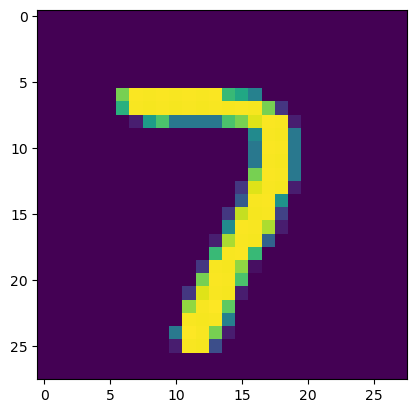

In [22]:
# Wandele Xsamp in ein Numpy-Array um
Xsamp_numpy = Xsamp.numpy()

# Zeige das Bild mit imshow
plt.imshow(Xsamp_numpy.reshape(28, 28))

In [23]:
print(ysamp)

tf.Tensor([7], shape=(1,), dtype=int32)


In [24]:
# Ihre Decorators

def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper
def my_timer(orig_func):

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

## Die Session ausführen

Jetzt ist es Zeit unsere Session auszuführen! Achte darauf wie wir zwei Schleifen verwenden. Die äußere, die die Epochs durchläuft, und die innere, die die Batches für jede Epoch des Trainings ausführt.

## Wichtig, hier wurden aus zeitlichen Gründen mit 1% der Daten gearbeitet. Der Code ist mit jeder Prozentzahl reproduzierbar.

Es wurde aus zeitlicher und übersichtlicher Sicht eine View sowie eine Abfrage des gewünschten Prozentsatzes eingebaut.

In [25]:
from tqdm import tqdm

# Eingabe vom Benutzer: Prozentsatz der Daten, die verarbeitet werden sollen
percentage_to_process = float(input("Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): "))
if percentage_to_process <= 0 or percentage_to_process > 100:
    print("Ungültiger Prozentsatz. Bitte geben Sie einen Wert zwischen 0 und 100 ein.")
    exit()

# Berechnen Sie die Anzahl der Datensätze, die verarbeitet werden sollen
n_samples_to_process = int(n_samples * (percentage_to_process / 100))

# Training Epochs
for epoch in range(training_epochs):
    avg_cost = 0.0
    total_batch = int(n_samples_to_process / batch_size)

    for i in tqdm(range(total_batch)):
        # Den nächsten Batch an Trainingsdaten und -labels nehmen
        batch_x = x_train[i * batch_size: (i + 1) * batch_size].reshape(-1, n_input)
        batch_y = y_train[i * batch_size: (i + 1) * batch_size]

        # Führen Sie die Optimierung und Cost-Berechnung durch
        with tf.GradientTape() as tape:
            pred = multilayer_perceptron(batch_x, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=batch_y, logits=pred))
        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))

        avg_cost += loss / total_batch

    print("Epoch: {} Cost={:.4f}".format(epoch + 1, avg_cost))

print("Modellierung ist beendet: {} Epochs of Training".format(training_epochs))


Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): 1


  0%|          | 2/560 [00:00<00:28, 19.43it/s]

multilayer_perceptron ran in: 0.003982067108154297 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010044574737548828 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


  2%|▏         | 10/560 [00:00<00:18, 30.12it/s]

multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009829998016357422 sec
multilayer_perceptron ran in: 0.002018451690673828 sec
multilayer_perceptron ran in: 0.002001523971557617 sec


  3%|▎         | 18/560 [00:00<00:17, 31.47it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002005338668823242 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.002013683319091797 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


  5%|▍         | 26/560 [00:00<00:16, 32.48it/s]

multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0019860267639160156 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010180473327636719 sec


  6%|▌         | 34/560 [00:01<00:15, 32.91it/s]

multilayer_perceptron ran in: 0.002017498016357422 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.002001047134399414 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


  7%|▋         | 38/560 [00:01<00:15, 32.95it/s]

multilayer_perceptron ran in: 0.001985788345336914 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009932518005371094 sec
multilayer_perceptron ran in: 0.0019991397857666016 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0019876956939697266 sec


  8%|▊         | 46/560 [00:01<00:16, 32.02it/s]

multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002001047134399414 sec
multilayer_perceptron ran in: 0.0020020008087158203 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 10%|▉         | 54/560 [00:01<00:15, 32.30it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010173320770263672 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 10%|█         | 58/560 [00:01<00:15, 32.37it/s]

multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020036697387695312 sec


 12%|█▏        | 66/560 [00:02<00:15, 31.74it/s]

multilayer_perceptron ran in: 0.0009987354278564453 sec
multilayer_perceptron ran in: 0.0009989738464355469 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009868144989013672 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0030007362365722656 sec


 12%|█▎        | 70/560 [00:02<00:15, 31.15it/s]

multilayer_perceptron ran in: 0.0009980201721191406 sec
multilayer_perceptron ran in: 0.000995635986328125 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0020165443420410156 sec
multilayer_perceptron ran in: 0.0020017623901367188 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec


 14%|█▍        | 78/560 [00:02<00:16, 29.89it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002001523971557617 sec


 15%|█▌        | 85/560 [00:02<00:15, 30.69it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010023117065429688 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0019991397857666016 sec


 17%|█▋        | 93/560 [00:02<00:15, 31.11it/s]

multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0009989738464355469 sec
multilayer_perceptron ran in: 0.0009984970092773438 sec
multilayer_perceptron ran in: 0.0020017623901367188 sec


 17%|█▋        | 97/560 [00:03<00:14, 31.23it/s]

multilayer_perceptron ran in: 0.0020072460174560547 sec
multilayer_perceptron ran in: 0.0010030269622802734 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec


 19%|█▉        | 105/560 [00:03<00:14, 31.96it/s]

multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.002001047134399414 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 20%|██        | 113/560 [00:03<00:14, 31.46it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019986629486083984 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0020020008087158203 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 21%|██        | 117/560 [00:03<00:14, 30.96it/s]

multilayer_perceptron ran in: 0.0009975433349609375 sec
multilayer_perceptron ran in: 0.0009989738464355469 sec
multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002000093460083008 sec


 22%|██▏       | 125/560 [00:03<00:14, 30.86it/s]

multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.001004934310913086 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0020008087158203125 sec


 23%|██▎       | 129/560 [00:04<00:13, 31.42it/s]

multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.001001596450805664 sec


 24%|██▍       | 137/560 [00:04<00:13, 31.87it/s]

multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.001997232437133789 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 26%|██▌       | 145/560 [00:04<00:13, 31.50it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0020008087158203125 sec


 27%|██▋       | 149/560 [00:04<00:13, 31.52it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001003265380859375 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009965896606445312 sec
multilayer_perceptron ran in: 0.0010035037994384766 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec


 28%|██▊       | 157/560 [00:04<00:12, 32.20it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002004384994506836 sec
multilayer_perceptron ran in: 0.0010170936584472656 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009832382202148438 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


 29%|██▉       | 165/560 [00:05<00:12, 31.35it/s]

multilayer_perceptron ran in: 0.0019969940185546875 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010097026824951172 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec


 30%|███       | 169/560 [00:05<00:12, 31.92it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 32%|███▏      | 177/560 [00:05<00:11, 32.15it/s]

multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009989738464355469 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0020143985748291016 sec


 33%|███▎      | 185/560 [00:05<00:11, 32.62it/s]

multilayer_perceptron ran in: 0.0010044574737548828 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009889602661132812 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 34%|███▍      | 193/560 [00:06<00:11, 32.98it/s]

multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0009870529174804688 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0020036697387695312 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020127296447753906 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec


 36%|███▌      | 201/560 [00:06<00:10, 33.14it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0019903182983398438 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009868144989013672 sec
multilayer_perceptron ran in: 0.001001596450805664 sec


 37%|███▋      | 209/560 [00:06<00:10, 32.75it/s]

multilayer_perceptron ran in: 0.0019865036010742188 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec


 39%|███▉      | 217/560 [00:06<00:10, 33.19it/s]

multilayer_perceptron ran in: 0.0010030269622802734 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.001996278762817383 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec


 39%|███▉      | 221/560 [00:06<00:10, 33.40it/s]

multilayer_perceptron ran in: 0.0010023117065429688 sec
multilayer_perceptron ran in: 0.0009958744049072266 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 41%|████      | 229/560 [00:07<00:09, 33.57it/s]

multilayer_perceptron ran in: 0.0010111331939697266 sec
multilayer_perceptron ran in: 0.0010037422180175781 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 42%|████▏     | 237/560 [00:07<00:09, 33.33it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010027885437011719 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 44%|████▍     | 245/560 [00:07<00:09, 33.56it/s]

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0019991397857666016 sec
multilayer_perceptron ran in: 0.00099945068359375 sec


 45%|████▌     | 253/560 [00:07<00:09, 33.64it/s]

multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.000982522964477539 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009953975677490234 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec


 47%|████▋     | 261/560 [00:08<00:08, 33.45it/s]

multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.001010894775390625 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001995086669921875 sec
multilayer_perceptron ran in: 0.0010161399841308594 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 48%|████▊     | 269/560 [00:08<00:09, 32.05it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009958744049072266 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009970664978027344 sec
multilayer_perceptron ran in: 0.001001119613647461 sec


 49%|████▉     | 277/560 [00:08<00:08, 32.08it/s]

multilayer_perceptron ran in: 0.0019989013671875 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0020017623901367188 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.000986337661743164 sec
multilayer_perceptron ran in: 0.001003265380859375 sec
multilayer_perceptron ran in: 0.0020122528076171875 sec
multilayer_perceptron ran in: 0.001001119613647461 sec


 51%|█████     | 285/560 [00:08<00:08, 32.77it/s]

multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.001003265380859375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010051727294921875 sec


 52%|█████▏    | 293/560 [00:09<00:08, 32.63it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019865036010742188 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec


 53%|█████▎    | 297/560 [00:09<00:08, 32.12it/s]

multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 54%|█████▍    | 305/560 [00:09<00:08, 30.96it/s]

multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0019991397857666016 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0020051002502441406 sec


 56%|█████▌    | 313/560 [00:09<00:07, 31.40it/s]

multilayer_perceptron ran in: 0.0009865760803222656 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010166168212890625 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019986629486083984 sec
multilayer_perceptron ran in: 0.0020165443420410156 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 57%|█████▋    | 321/560 [00:10<00:07, 31.43it/s]

multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.001990079879760742 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010077953338623047 sec
multilayer_perceptron ran in: 0.002000093460083008 sec


 58%|█████▊    | 325/560 [00:10<00:07, 31.78it/s]

multilayer_perceptron ran in: 0.002001523971557617 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0019910335540771484 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec


 59%|█████▉    | 333/560 [00:10<00:07, 32.20it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010149478912353516 sec
multilayer_perceptron ran in: 0.0010149478912353516 sec
multilayer_perceptron ran in: 0.0020127296447753906 sec
multilayer_perceptron ran in: 0.0009958744049072266 sec


 61%|██████    | 341/560 [00:10<00:06, 31.81it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009965896606445312 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0009875297546386719 sec
multilayer_perceptron ran in: 0.0030014514923095703 sec


 62%|██████▏   | 345/560 [00:10<00:06, 31.79it/s]

multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0020008087158203125 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0009801387786865234 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 63%|██████▎   | 353/560 [00:11<00:06, 32.23it/s]

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0019872188568115234 sec
multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.00101470947265625 sec
multilayer_perceptron ran in: 0.0009870529174804688 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 64%|██████▍   | 361/560 [00:11<00:06, 32.27it/s]

multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020134449005126953 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec


 65%|██████▌   | 365/560 [00:11<00:06, 31.83it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019893646240234375 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 67%|██████▋   | 373/560 [00:11<00:05, 32.33it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019888877868652344 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec


 68%|██████▊   | 381/560 [00:11<00:05, 31.72it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0020155906677246094 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002006053924560547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 69%|██████▉   | 389/560 [00:12<00:05, 32.54it/s]

multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


 70%|███████   | 393/560 [00:12<00:05, 32.39it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010192394256591797 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019919872283935547 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec


 72%|███████▏  | 401/560 [00:12<00:04, 32.22it/s]

multilayer_perceptron ran in: 0.0010192394256591797 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010027885437011719 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 73%|███████▎  | 409/560 [00:12<00:04, 31.88it/s]

multilayer_perceptron ran in: 0.0019807815551757812 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009963512420654297 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 74%|███████▍  | 417/560 [00:13<00:04, 31.69it/s]

multilayer_perceptron ran in: 0.0010039806365966797 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001998424530029297 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 75%|███████▌  | 421/560 [00:13<00:04, 31.85it/s]

multilayer_perceptron ran in: 0.001984834671020508 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0020051002502441406 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.002008199691772461 sec
multilayer_perceptron ran in: 0.0010135173797607422 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 77%|███████▋  | 429/560 [00:13<00:04, 31.62it/s]

multilayer_perceptron ran in: 0.001984834671020508 sec
multilayer_perceptron ran in: 0.0009970664978027344 sec
multilayer_perceptron ran in: 0.0010039806365966797 sec
multilayer_perceptron ran in: 0.0010116100311279297 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 78%|███████▊  | 437/560 [00:13<00:03, 32.12it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0019850730895996094 sec
multilayer_perceptron ran in: 0.0020020008087158203 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.001999378204345703 sec


 79%|███████▉  | 441/560 [00:13<00:03, 31.87it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009684562683105469 sec
multilayer_perceptron ran in: 0.0019974708557128906 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.002000093460083008 sec


 80%|████████  | 449/560 [00:14<00:03, 31.92it/s]

multilayer_perceptron ran in: 0.0009837150573730469 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009915828704833984 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009856224060058594 sec


 81%|████████  | 453/560 [00:14<00:03, 32.10it/s]

multilayer_perceptron ran in: 0.002005338668823242 sec
multilayer_perceptron ran in: 0.000982046127319336 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 82%|████████▏ | 461/560 [00:14<00:03, 31.95it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009815692901611328 sec
multilayer_perceptron ran in: 0.001018524169921875 sec
multilayer_perceptron ran in: 0.0019865036010742188 sec
multilayer_perceptron ran in: 0.0009851455688476562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009965896606445312 sec


 84%|████████▍ | 469/560 [00:14<00:02, 32.69it/s]

multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec


 85%|████████▌ | 477/560 [00:14<00:02, 33.10it/s]

multilayer_perceptron ran in: 0.0020008087158203125 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 86%|████████▌ | 481/560 [00:15<00:02, 32.92it/s]

multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009870529174804688 sec
multilayer_perceptron ran in: 0.0019969940185546875 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec


 87%|████████▋ | 489/560 [00:15<00:02, 32.55it/s]

multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.0009984970092773438 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 89%|████████▉ | 497/560 [00:15<00:01, 32.87it/s]

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.002001523971557617 sec
multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009877681732177734 sec


 90%|█████████ | 505/560 [00:15<00:01, 32.61it/s]

multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019979476928710938 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0020155906677246094 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 92%|█████████▏| 513/560 [00:15<00:01, 32.53it/s]

multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0009989738464355469 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.002002239227294922 sec
multilayer_perceptron ran in: 0.0010023117065429688 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec


 93%|█████████▎| 521/560 [00:16<00:01, 32.99it/s]

multilayer_perceptron ran in: 0.0009851455688476562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0009980201721191406 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 94%|█████████▍| 525/560 [00:16<00:01, 32.93it/s]

multilayer_perceptron ran in: 0.0009818077087402344 sec
multilayer_perceptron ran in: 0.001986980438232422 sec
multilayer_perceptron ran in: 0.0010023117065429688 sec
multilayer_perceptron ran in: 0.0019991397857666016 sec
multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 95%|█████████▌| 533/560 [00:16<00:00, 33.11it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec


 97%|█████████▋| 541/560 [00:16<00:00, 33.40it/s]

multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009799003601074219 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 98%|█████████▊| 549/560 [00:17<00:00, 33.42it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.002019166946411133 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 99%|█████████▉| 557/560 [00:17<00:00, 33.24it/s]

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


100%|██████████| 560/560 [00:17<00:00, 32.16it/s]


multilayer_perceptron ran in: 0.0010006427764892578 sec
Epoch: 1 Cost=15826.9336


  1%|          | 4/560 [00:00<00:16, 33.47it/s]

multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0020008087158203125 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec


  2%|▏         | 12/560 [00:00<00:16, 33.43it/s]

multilayer_perceptron ran in: 0.0010044574737548828 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009875297546386719 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


  4%|▎         | 20/560 [00:00<00:16, 33.34it/s]

multilayer_perceptron ran in: 0.0010023117065429688 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.002002239227294922 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec


  4%|▍         | 24/560 [00:00<00:16, 32.96it/s]

multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec


  5%|▌         | 28/560 [00:00<00:16, 32.85it/s]

multilayer_perceptron ran in: 0.0009963512420654297 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


  6%|▌         | 32/560 [00:00<00:16, 32.66it/s]

multilayer_perceptron ran in: 0.0020186901092529297 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.001016855239868164 sec


  6%|▋         | 36/560 [00:01<00:16, 32.53it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009818077087402344 sec
multilayer_perceptron ran in: 0.0010020732879638672 sec


  7%|▋         | 40/560 [00:01<00:15, 32.69it/s]

multilayer_perceptron ran in: 0.0010013580322265625 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.00201416015625 sec


  8%|▊         | 44/560 [00:01<00:15, 32.72it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010020732879638672 sec
multilayer_perceptron ran in: 0.0010030269622802734 sec
multilayer_perceptron ran in: 0.0009984970092773438 sec
multilayer_perceptron ran in: 0.0020008087158203125 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec


  9%|▉         | 52/560 [00:01<00:15, 32.89it/s]

multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0019867420196533203 sec
multilayer_perceptron ran in: 0.0010044574737548828 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec


 10%|█         | 56/560 [00:01<00:15, 32.94it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0020012855529785156 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 11%|█         | 60/560 [00:01<00:15, 32.89it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec


 11%|█▏        | 64/560 [00:01<00:15, 32.78it/s]

multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009984970092773438 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 12%|█▏        | 68/560 [00:02<00:15, 32.78it/s]

multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.002001047134399414 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 13%|█▎        | 72/560 [00:02<00:14, 32.78it/s]

multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec


 14%|█▎        | 76/560 [00:02<00:14, 32.79it/s]

multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec


 14%|█▍        | 80/560 [00:02<00:14, 32.95it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0020020008087158203 sec
multilayer_perceptron ran in: 0.0020020008087158203 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec


 15%|█▌        | 84/560 [00:02<00:14, 32.98it/s]

multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001001119613647461 sec


 16%|█▌        | 88/560 [00:02<00:14, 33.17it/s]

multilayer_perceptron ran in: 0.0019850730895996094 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec


 16%|█▋        | 92/560 [00:02<00:14, 32.97it/s]

multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0010027885437011719 sec


 17%|█▋        | 96/560 [00:03<00:18, 25.15it/s]

multilayer_perceptron ran in: 0.001999378204345703 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec


 19%|█▊        | 104/560 [00:03<00:15, 28.61it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010025501251220703 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec


 20%|██        | 112/560 [00:03<00:14, 30.88it/s]

multilayer_perceptron ran in: 0.0010199546813964844 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.002000093460083008 sec


 21%|██▏       | 120/560 [00:03<00:13, 31.94it/s]

multilayer_perceptron ran in: 0.0010139942169189453 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010013580322265625 sec


 23%|██▎       | 128/560 [00:04<00:13, 32.66it/s]

multilayer_perceptron ran in: 0.001001596450805664 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010175704956054688 sec
multilayer_perceptron ran in: 0.0009813308715820312 sec


 24%|██▍       | 136/560 [00:04<00:12, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:12, 33.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:12, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002008199691772461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:05<00:11, 33.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563572883605957 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 172/560 [00:05<00:11, 34.25it/s]

multilayer_perceptron ran in: 0.015621662139892578 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 33.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015632152557373047 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 34.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610456466674805 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:11, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:06<00:10, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:10, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 34.23it/s]

multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015608549118041992 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:06<00:09, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:09, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622377395629883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 33.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635013580322266 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:08, 34.12it/s]

multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:08<00:08, 33.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613555908203125 sec


 49%|████▊     | 272/560 [00:08<00:08, 34.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 276/560 [00:08<00:08, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638113021850586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 33.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:07, 33.84it/s]

multilayer_perceptron ran in: 0.0020177364349365234 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:07, 32.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006507396697998047 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:07, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562047004699707 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 33.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 320/560 [00:09<00:07, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:09<00:06, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 332/560 [00:10<00:06, 33.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:06, 33.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 62%|██████▏   | 348/560 [00:10<00:06, 33.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636444091796875 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▎   | 356/560 [00:10<00:06, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▌   | 364/560 [00:11<00:05, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006506681442260742 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 368/560 [00:11<00:05, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 376/560 [00:11<00:05, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec


 69%|██████▊   | 384/560 [00:11<00:05, 34.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 388/560 [00:11<00:05, 32.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 396/560 [00:11<00:04, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 404/560 [00:12<00:04, 33.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▎  | 412/560 [00:12<00:04, 34.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:12<00:04, 32.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 428/560 [00:12<00:03, 33.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 432/560 [00:13<00:03, 33.41it/s]

multilayer_perceptron ran in: 0.015643835067749023 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▊  | 440/560 [00:13<00:03, 33.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|████████  | 448/560 [00:13<00:03, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 456/560 [00:13<00:03, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 460/560 [00:13<00:02, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▎ | 468/560 [00:14<00:02, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▌ | 476/560 [00:14<00:02, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 484/560 [00:14<00:02, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:14<00:02, 33.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▊ | 496/560 [00:14<00:01, 33.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|█████████ | 504/560 [00:15<00:01, 33.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 512/560 [00:15<00:01, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 520/560 [00:15<00:01, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:15<00:00, 34.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561284065246582 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 34.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 548/560 [00:16<00:00, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:16<00:00, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:16<00:00, 33.21it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 2 Cost=13882.5078


  1%|          | 4/560 [00:00<00:16, 34.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:17, 31.98it/s]

multilayer_perceptron ran in: 0.006511688232421875 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 33.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649795532226562 sec


  4%|▎         | 20/560 [00:00<00:16, 33.28it/s]

multilayer_perceptron ran in: 0.01560664176940918 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:15, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:16, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:15, 33.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:15, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510734558105469 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 33.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 32.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▊         | 48/560 [00:01<00:15, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015604734420776367 sec


  9%|▉         | 52/560 [00:01<00:15, 33.43it/s]

multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:14, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015640735626220703 sec


 11%|█▏        | 64/560 [00:01<00:15, 32.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:15, 32.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 32.44it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 33.04it/s]

multilayer_perceptron ran in: 0.015615701675415039 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▌        | 84/560 [00:02<00:14, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:13, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 92/560 [00:02<00:14, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:14, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:03<00:13, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065097808837890625 sec
multilayer_perceptron ran in: 0.015611648559570312 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 33.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508350372314453 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 120/560 [00:03<00:13, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:13, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 128/560 [00:03<00:12, 33.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:12, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:12, 34.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 33.71it/s]

multilayer_perceptron ran in: 0.006524324417114258 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:12, 34.11it/s]

multilayer_perceptron ran in: 0.015639066696166992 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 32.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:12, 33.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:11, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:11, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:05<00:11, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613079071044922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 34.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 34.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 33.75it/s]

multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:10, 33.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:05<00:10, 33.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:05<00:10, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:10, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:10, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508827209472656 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 33.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 34.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:09, 34.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:06<00:09, 34.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:06<00:09, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015641450881958008 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:06<00:10, 32.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:09, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 33.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 33.80it/s]

multilayer_perceptron ran in: 0.015612602233886719 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:11, 25.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:08<00:10, 29.07it/s]

multilayer_perceptron ran in: 0.015641450881958008 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:09, 31.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 32.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.015628814697265625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:08, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630483627319336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:08, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:07, 33.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015621185302734375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▌    | 308/560 [00:09<00:07, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 316/560 [00:09<00:07, 33.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015606164932250977 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:09<00:06, 34.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:09<00:06, 33.77it/s]

multilayer_perceptron ran in: 0.0065135955810546875 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec


 60%|██████    | 336/560 [00:10<00:06, 34.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015608072280883789 sec
multilayer_perceptron ran in: 0.015622377395629883 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510496139526367 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▎   | 356/560 [00:10<00:06, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▌   | 364/560 [00:10<00:05, 34.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564788818359375 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 34.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 380/560 [00:11<00:05, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▊   | 384/560 [00:11<00:05, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 392/560 [00:11<00:05, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01579570770263672 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 32.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 408/560 [00:12<00:04, 33.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 416/560 [00:12<00:04, 33.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:12<00:04, 33.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 428/560 [00:12<00:03, 34.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 436/560 [00:13<00:03, 34.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612125396728516 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 444/560 [00:13<00:03, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065228939056396484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 452/560 [00:13<00:03, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 456/560 [00:13<00:03, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 464/560 [00:13<00:02, 33.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 472/560 [00:14<00:02, 33.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 480/560 [00:14<00:02, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 484/560 [00:14<00:02, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:14<00:01, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 500/560 [00:15<00:01, 33.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 508/560 [00:15<00:01, 34.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 516/560 [00:15<00:01, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 520/560 [00:15<00:01, 33.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:15<00:00, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649080276489258 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 34.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 33.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 548/560 [00:16<00:00, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639305114746094 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:16<00:00, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:16<00:00, 33.29it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 3 Cost=17218.5059


  1%|          | 4/560 [00:00<00:14, 37.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:16, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 33.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 32.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:16, 33.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:15, 33.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:15, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 32.89it/s]

multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 32.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510734558105469 sec
multilayer_perceptron ran in: 0.015625715255737305 sec


  9%|▊         | 48/560 [00:01<00:15, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015609502792358398 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 32.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec


 10%|█         | 56/560 [00:01<00:15, 33.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:15, 32.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:14, 33.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec


 13%|█▎        | 72/560 [00:02<00:14, 33.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 34.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015648603439331055 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▌        | 84/560 [00:02<00:13, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 92/560 [00:02<00:14, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:13, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:02<00:13, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006527900695800781 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 33.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec


 19%|█▉        | 108/560 [00:03<00:17, 26.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|█▉        | 111/560 [00:03<00:16, 26.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 115/560 [00:03<00:15, 28.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 119/560 [00:03<00:14, 30.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 123/560 [00:03<00:13, 31.63it/s]

multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 127/560 [00:03<00:13, 31.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642881393432617 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630245208740234 sec


 24%|██▍       | 135/560 [00:04<00:12, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 143/560 [00:04<00:12, 32.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 151/560 [00:04<00:11, 34.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec


 28%|██▊       | 155/560 [00:04<00:12, 33.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 163/560 [00:04<00:11, 33.77it/s]

multilayer_perceptron ran in: 0.00653529167175293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611648559570312 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|██▉       | 167/560 [00:05<00:11, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 175/560 [00:05<00:11, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015607357025146484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 183/560 [00:05<00:11, 32.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565384864807129 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 191/560 [00:05<00:11, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▍      | 195/560 [00:05<00:10, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628814697265625 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 203/560 [00:06<00:10, 34.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510496139526367 sec


 38%|███▊      | 211/560 [00:06<00:10, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec


 38%|███▊      | 215/560 [00:06<00:10, 33.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|███▉      | 223/560 [00:06<00:09, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 231/560 [00:07<00:09, 34.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524324417114258 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 239/560 [00:07<00:09, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564168930053711 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 247/560 [00:07<00:09, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▍     | 251/560 [00:07<00:09, 33.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 259/560 [00:07<00:08, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 267/560 [00:08<00:08, 34.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629053115844727 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 275/560 [00:08<00:08, 34.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|████▉     | 279/560 [00:08<00:08, 33.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 287/560 [00:08<00:08, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 295/560 [00:08<00:07, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015631437301635742 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 303/560 [00:09<00:07, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 311/560 [00:09<00:07, 34.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 315/560 [00:09<00:07, 32.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510019302368164 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 323/560 [00:09<00:07, 33.18it/s]

multilayer_perceptron ran in: 0.015620708465576172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 327/560 [00:09<00:06, 33.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|█████▉    | 335/560 [00:10<00:06, 34.04it/s]

multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 343/560 [00:10<00:06, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 351/560 [00:10<00:06, 34.11it/s]

multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 355/560 [00:10<00:06, 32.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015650272369384766 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628576278686523 sec


 65%|██████▍   | 363/560 [00:10<00:05, 33.16it/s]

multilayer_perceptron ran in: 0.015642166137695312 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 371/560 [00:11<00:05, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 379/560 [00:11<00:05, 34.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 387/560 [00:11<00:05, 34.19it/s]

multilayer_perceptron ran in: 0.015651464462280273 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec


 70%|██████▉   | 391/560 [00:11<00:05, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 399/560 [00:12<00:04, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610694885253906 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 407/560 [00:12<00:04, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649080276489258 sec


 74%|███████▍  | 415/560 [00:12<00:04, 34.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▍  | 419/560 [00:12<00:04, 32.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 427/560 [00:12<00:03, 33.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 435/560 [00:13<00:03, 34.68it/s]

multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 443/560 [00:13<00:03, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|███████▉  | 447/560 [00:13<00:03, 33.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 455/560 [00:13<00:03, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510734558105469 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636444091796875 sec


 83%|████████▎ | 463/560 [00:13<00:02, 34.16it/s]

multilayer_perceptron ran in: 0.015608549118041992 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 467/560 [00:14<00:02, 32.94it/s]

multilayer_perceptron ran in: 0.006537437438964844 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▍ | 475/560 [00:14<00:02, 34.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015644311904907227 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 483/560 [00:14<00:02, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 491/560 [00:14<00:02, 34.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 499/560 [00:14<00:01, 35.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 507/560 [00:15<00:01, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 511/560 [00:15<00:01, 33.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0020017623901367188 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 519/560 [00:15<00:01, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 523/560 [00:15<00:01, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▍| 531/560 [00:15<00:00, 33.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 539/560 [00:16<00:00, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 547/560 [00:16<00:00, 33.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065135955810546875 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 555/560 [00:16<00:00, 32.78it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:16<00:00, 33.34it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010294914245605469 sec
multilayer_perceptron ran in: 0.01564168930053711 sec
Epoch: 4 Cost=34392.2109


  1%|          | 4/560 [00:00<00:16, 34.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:16, 33.78it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 33.84it/s]

multilayer_perceptron ran in: 0.015608549118041992 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 32.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▎         | 20/560 [00:00<00:16, 33.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:16, 32.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:16, 32.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:15, 33.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 33.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622854232788086 sec


  8%|▊         | 44/560 [00:01<00:15, 33.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▊         | 48/560 [00:01<00:15, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 33.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629053115844727 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:14, 34.09it/s]

multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:15, 32.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:14, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563858985900879 sec


 14%|█▎        | 76/560 [00:02<00:14, 33.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▌        | 84/560 [00:02<00:13, 34.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 32.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 92/560 [00:02<00:14, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015608787536621094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:14, 33.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:02<00:13, 33.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565074920654297 sec
multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 33.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:12, 34.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 128/560 [00:03<00:13, 32.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:12, 33.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:12, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:12, 34.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:11, 34.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:11, 34.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:11, 33.78it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:11, 33.99it/s]

multilayer_perceptron ran in: 0.015645742416381836 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:04<00:11, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 172/560 [00:05<00:11, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 34.31it/s]

multilayer_perceptron ran in: 0.015806913375854492 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 33.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:11, 33.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:10, 33.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:05<00:10, 34.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:05<00:10, 34.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:10, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:10, 33.95it/s]

multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 34.13it/s]

multilayer_perceptron ran in: 0.0009829998016357422 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 33.39it/s]

multilayer_perceptron ran in: 0.015628814697265625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:06<00:09, 33.72it/s]

multilayer_perceptron ran in: 0.015606164932250977 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:06<00:09, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156557559967041 sec


 42%|████▏     | 236/560 [00:07<00:09, 33.95it/s]

multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 33.78it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 34.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636444091796875 sec


 46%|████▋     | 260/560 [00:07<00:08, 33.37it/s]

multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 268/560 [00:07<00:08, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:08, 33.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 33.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:08, 32.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:08, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:08<00:07, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015633106231689453 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:09, 25.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:08, 29.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 316/560 [00:09<00:07, 30.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:09<00:07, 31.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 332/560 [00:10<00:07, 32.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:06, 33.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0 sec


 62%|██████▏   | 348/560 [00:10<00:06, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 33.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563119888305664 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec


 64%|██████▍   | 360/560 [00:10<00:06, 32.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 368/560 [00:11<00:05, 33.12it/s]

multilayer_perceptron ran in: 0.015613317489624023 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 33.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015654563903808594 sec


 68%|██████▊   | 380/560 [00:11<00:05, 34.02it/s]

multilayer_perceptron ran in: 0.01563882827758789 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 388/560 [00:11<00:05, 32.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 396/560 [00:11<00:04, 34.27it/s]

multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 34.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 408/560 [00:12<00:04, 34.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636920928955078 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 416/560 [00:12<00:04, 33.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065250396728515625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 424/560 [00:12<00:04, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 432/560 [00:12<00:03, 34.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 436/560 [00:13<00:03, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01560831069946289 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 444/560 [00:13<00:03, 34.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 452/560 [00:13<00:03, 32.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006523609161376953 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 460/560 [00:13<00:02, 34.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▎ | 468/560 [00:14<00:02, 33.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▌ | 476/560 [00:14<00:02, 33.47it/s]

multilayer_perceptron ran in: 0.01565241813659668 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 484/560 [00:14<00:02, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 488/560 [00:14<00:02, 34.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▊ | 496/560 [00:14<00:01, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|█████████ | 504/560 [00:15<00:01, 33.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 508/560 [00:15<00:01, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 516/560 [00:15<00:01, 33.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▎| 524/560 [00:15<00:01, 33.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▌| 532/560 [00:15<00:00, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 97%|█████████▋| 544/560 [00:16<00:00, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622615814208984 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▊| 552/560 [00:16<00:00, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:16<00:00, 33.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563549041748047 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:16<00:00, 33.34it/s]


multilayer_perceptron ran in: 0.0 sec
Epoch: 5 Cost=50062.9414


  1%|          | 4/560 [00:00<00:16, 34.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612125396728516 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:15, 34.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 32.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:15, 34.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:15, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 33.85it/s]

multilayer_perceptron ran in: 0.015650272369384766 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:14, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:15, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563119888305664 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 33.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:13, 34.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:13, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:02<00:13, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 33.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:12, 34.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611648559570312 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:12, 33.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 34.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563739776611328 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:11, 34.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:12, 33.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:11, 33.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 171/560 [00:05<00:14, 26.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065364837646484375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 175/560 [00:05<00:13, 28.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563286781311035 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 183/560 [00:05<00:12, 30.93it/s]

multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 191/560 [00:05<00:11, 32.68it/s]

multilayer_perceptron ran in: 0.006529092788696289 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 199/560 [00:06<00:10, 33.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 207/560 [00:06<00:10, 33.78it/s]

multilayer_perceptron ran in: 0.01564168930053711 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 211/560 [00:06<00:10, 33.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 219/560 [00:06<00:10, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 227/560 [00:06<00:09, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 235/560 [00:07<00:09, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 239/560 [00:07<00:09, 34.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 247/560 [00:07<00:09, 33.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565861701965332 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 255/560 [00:07<00:08, 34.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 259/560 [00:07<00:08, 34.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 267/560 [00:08<00:08, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec


 49%|████▉     | 275/560 [00:08<00:08, 34.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|████▉     | 279/560 [00:08<00:08, 32.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 287/560 [00:08<00:08, 33.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564168930053711 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 295/560 [00:08<00:07, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015658140182495117 sec
multilayer_perceptron ran in: 0.0156404972076416 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 303/560 [00:09<00:07, 34.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156402587890625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▍    | 307/560 [00:09<00:07, 34.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006528139114379883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 315/560 [00:09<00:07, 33.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639781951904297 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 323/560 [00:09<00:07, 33.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 331/560 [00:09<00:06, 33.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|█████▉    | 335/560 [00:10<00:06, 33.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 343/560 [00:10<00:06, 33.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 351/560 [00:10<00:06, 34.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 359/560 [00:10<00:05, 33.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▍   | 363/560 [00:10<00:05, 34.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 371/560 [00:11<00:05, 33.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 379/560 [00:11<00:05, 34.75it/s]

multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 387/560 [00:11<00:05, 33.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00202178955078125 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|██████▉   | 391/560 [00:11<00:05, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 399/560 [00:11<00:04, 33.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 407/560 [00:12<00:04, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 74%|███████▍  | 415/560 [00:12<00:04, 34.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 423/560 [00:12<00:04, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 427/560 [00:12<00:03, 34.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 435/560 [00:12<00:03, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.015613079071044922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 443/560 [00:13<00:03, 33.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 451/560 [00:13<00:03, 33.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 455/560 [00:13<00:03, 34.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510734558105469 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 463/560 [00:13<00:02, 32.85it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 471/560 [00:14<00:02, 33.67it/s]

multilayer_perceptron ran in: 0.006512641906738281 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 479/560 [00:14<00:02, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 487/560 [00:14<00:02, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628814697265625 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 491/560 [00:14<00:02, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 89%|████████▉ | 499/560 [00:14<00:01, 33.72it/s]

multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 507/560 [00:15<00:01, 33.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 515/560 [00:15<00:01, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509304046630859 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 519/560 [00:15<00:01, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 527/560 [00:15<00:01, 32.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 535/560 [00:15<00:00, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015633821487426758 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 97%|█████████▋| 543/560 [00:16<00:00, 33.94it/s]

multilayer_perceptron ran in: 0.015639543533325195 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 551/560 [00:16<00:00, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636682510375977 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 555/560 [00:16<00:00, 34.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:16<00:00, 33.49it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 6 Cost=66310.2109


  1%|          | 4/560 [00:00<00:14, 37.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564168930053711 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:15, 35.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▎         | 20/560 [00:00<00:16, 33.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:15, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610694885253906 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:15, 34.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 34.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▊         | 48/560 [00:01<00:14, 34.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 10%|█         | 56/560 [00:01<00:15, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:14, 34.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:14, 32.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 33.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 15%|█▌        | 84/560 [00:02<00:14, 33.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002008199691772461 sec


 16%|█▋        | 92/560 [00:02<00:13, 33.79it/s]

multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:13, 34.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:02<00:13, 34.15it/s]

multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|██        | 112/560 [00:03<00:12, 34.52it/s]

multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015621185302734375 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 120/560 [00:03<00:13, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:12, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:12, 33.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564764976501465 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 34.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 34.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524562835693359 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:12, 33.18it/s]

multilayer_perceptron ran in: 0.015620708465576172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:04<00:11, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 33.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510734558105469 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015654802322387695 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 34.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156400203704834 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:11, 32.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:05<00:10, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563715934753418 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:10, 34.67it/s]

multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 33.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 33.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:06<00:09, 33.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524801254272461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:06<00:09, 34.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 33.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 33.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 260/560 [00:07<00:09, 32.05it/s]

multilayer_perceptron ran in: 0.015641212463378906 sec
multilayer_perceptron ran in: 0.015605926513671875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:07<00:09, 31.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:08, 32.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 32.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:08, 32.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:08, 32.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635013580322266 sec
multilayer_perceptron ran in: 0.01561117172241211 sec


 54%|█████▎    | 300/560 [00:08<00:07, 32.61it/s]

multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:08, 31.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 32.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006529092788696289 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.01564192771911621 sec


 57%|█████▋    | 320/560 [00:09<00:07, 32.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:09<00:07, 32.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 332/560 [00:09<00:07, 32.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:06, 32.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 33.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 360/560 [00:10<00:06, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec


 65%|██████▌   | 364/560 [00:11<00:07, 25.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562786102294922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 371/560 [00:11<00:06, 28.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 379/560 [00:11<00:05, 30.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524085998535156 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 387/560 [00:11<00:05, 31.82it/s]

multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509065628051758 sec
multilayer_perceptron ran in: 0.0 sec


 70%|██████▉   | 391/560 [00:11<00:05, 32.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 399/560 [00:12<00:04, 32.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015640735626220703 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 407/560 [00:12<00:04, 31.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 411/560 [00:12<00:04, 31.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▍  | 419/560 [00:12<00:04, 31.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 423/560 [00:12<00:04, 32.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 431/560 [00:13<00:03, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 439/560 [00:13<00:03, 31.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015654563903808594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|███████▉  | 447/560 [00:13<00:03, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 451/560 [00:13<00:03, 31.78it/s]

multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 459/560 [00:13<00:03, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 467/560 [00:14<00:02, 31.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508827209472656 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 471/560 [00:14<00:02, 31.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 479/560 [00:14<00:02, 32.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 483/560 [00:14<00:02, 32.28it/s]

multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 491/560 [00:14<00:02, 32.49it/s]

multilayer_perceptron ran in: 0.01563405990600586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 499/560 [00:15<00:01, 32.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|████████▉ | 503/560 [00:15<00:01, 31.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 511/560 [00:15<00:01, 31.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 515/560 [00:15<00:01, 32.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649080276489258 sec
multilayer_perceptron ran in: 0.015620708465576172 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 523/560 [00:15<00:01, 32.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▍| 531/560 [00:16<00:00, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006516695022583008 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 539/560 [00:16<00:00, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 97%|█████████▋| 543/560 [00:16<00:00, 32.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00652313232421875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 551/560 [00:16<00:00, 32.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 32.72it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 7 Cost=81820.5625


  0%|          | 0/560 [00:00<?, ?it/s]

multilayer_perceptron ran in: 0.0 sec


  1%|          | 4/560 [00:00<00:16, 34.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec


  2%|▏         | 12/560 [00:00<00:18, 30.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623092651367188 sec


  4%|▎         | 20/560 [00:00<00:17, 31.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 32.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638351440429688 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:15, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:16, 32.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015659332275390625 sec


  8%|▊         | 44/560 [00:01<00:15, 33.05it/s]

multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 32.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:15, 31.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:15, 31.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509542465209961 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:15, 31.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635251998901367 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:15, 31.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec


 16%|█▌        | 88/560 [00:02<00:14, 31.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:14, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562786102294922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:03<00:14, 31.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622138977050781 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|██        | 112/560 [00:03<00:13, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065233707427978516 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 120/560 [00:03<00:13, 32.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564192771911621 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 128/560 [00:03<00:13, 33.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015633821487426758 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:04<00:12, 33.44it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:12, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612125396728516 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:12, 32.96it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:11, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:05<00:12, 32.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 32.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:10, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639543533325195 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:06<00:11, 32.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:10, 33.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 33.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 32.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 227/560 [00:07<00:12, 26.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 235/560 [00:07<00:10, 30.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 243/560 [00:07<00:10, 31.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 247/560 [00:07<00:09, 32.01it/s]

multilayer_perceptron ran in: 0.001092672348022461 sec
multilayer_perceptron ran in: 0.015622854232788086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 255/560 [00:07<00:09, 32.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562976837158203 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 263/560 [00:08<00:09, 32.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 271/560 [00:08<00:08, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 275/560 [00:08<00:08, 32.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 283/560 [00:08<00:08, 33.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630483627319336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 291/560 [00:09<00:08, 32.85it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 295/560 [00:09<00:08, 32.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 303/560 [00:09<00:07, 32.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638113021850586 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 311/560 [00:09<00:07, 33.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 319/560 [00:09<00:07, 32.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 323/560 [00:09<00:07, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 331/560 [00:10<00:06, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015652179718017578 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 339/560 [00:10<00:06, 33.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 343/560 [00:10<00:06, 33.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 351/560 [00:10<00:06, 32.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01560831069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 359/560 [00:11<00:06, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▍   | 363/560 [00:11<00:05, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509304046630859 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 371/560 [00:11<00:05, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 379/560 [00:11<00:05, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 387/560 [00:11<00:05, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 395/560 [00:12<00:05, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563882827758789 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 399/560 [00:12<00:04, 32.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 407/560 [00:12<00:04, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 415/560 [00:12<00:04, 32.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▍  | 419/560 [00:12<00:04, 32.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015614748001098633 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 427/560 [00:13<00:04, 32.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 435/560 [00:13<00:03, 32.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639305114746094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 443/560 [00:13<00:03, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|███████▉  | 447/560 [00:13<00:03, 33.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 455/560 [00:14<00:03, 32.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 463/560 [00:14<00:02, 33.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 471/560 [00:14<00:02, 33.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▍ | 475/560 [00:14<00:02, 32.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015634536743164062 sec
multilayer_perceptron ran in: 0.015631914138793945 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 483/560 [00:14<00:02, 33.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 491/560 [00:15<00:02, 33.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 499/560 [00:15<00:01, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524562835693359 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|████████▉ | 503/560 [00:15<00:01, 33.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563239097595215 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 511/560 [00:15<00:01, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0020122528076171875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec


 93%|█████████▎| 519/560 [00:15<00:01, 32.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 527/560 [00:16<00:00, 33.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 535/560 [00:16<00:00, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 539/560 [00:16<00:00, 32.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564931869506836 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 547/560 [00:16<00:00, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 555/560 [00:16<00:00, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015648841857910156 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630722045898438 sec


100%|██████████| 560/560 [00:17<00:00, 32.66it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 8 Cost=97883.2422


  0%|          | 0/560 [00:00<?, ?it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|          | 4/560 [00:00<00:17, 32.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:16, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:17, 32.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613079071044922 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▎         | 20/560 [00:00<00:16, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:15, 33.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:16, 32.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▊         | 48/560 [00:01<00:15, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 10%|█         | 56/560 [00:01<00:15, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:15, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:15, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:14, 33.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 33.22it/s]

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▌        | 84/560 [00:02<00:14, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610694885253906 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 32.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 92/560 [00:02<00:14, 32.88it/s]

multilayer_perceptron ran in: 0.0065250396728515625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642166137695312 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:13, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:03<00:14, 32.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:14, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|██        | 112/560 [00:03<00:13, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629291534423828 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 32.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 120/560 [00:03<00:13, 32.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:13, 33.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 128/560 [00:03<00:12, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec


 24%|██▍       | 136/560 [00:04<00:12, 33.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015631675720214844 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:12, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015609979629516602 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:12, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:11, 33.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015607833862304688 sec


 31%|███       | 172/560 [00:05<00:11, 32.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 33.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610933303833008 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:10, 34.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:06<00:10, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:11, 32.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065250396728515625 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 33.25it/s]

multilayer_perceptron ran in: 0.015619039535522461 sec
multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002096414566040039 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 32.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:06<00:09, 33.47it/s]

multilayer_perceptron ran in: 0.01564931869506836 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:09, 33.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 33.59it/s]

multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 32.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 33.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:08, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 260/560 [00:07<00:08, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:07<00:09, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 268/560 [00:08<00:08, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:08, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 276/560 [00:08<00:08, 32.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 31.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015615224838256836 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:08, 32.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:08, 33.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006528139114379883 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 296/560 [00:08<00:07, 33.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:07, 33.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:07, 32.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524562835693359 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▌    | 308/560 [00:09<00:07, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 316/560 [00:09<00:07, 33.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642404556274414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:09<00:07, 33.15it/s]

multilayer_perceptron ran in: 0.015636205673217773 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006528377532958984 sec


 59%|█████▉    | 332/560 [00:10<00:07, 32.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642404556274414 sec
multilayer_perceptron ran in: 0.0 sec


 60%|██████    | 336/560 [00:10<00:06, 33.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 32.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▎   | 356/560 [00:10<00:06, 32.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 360/560 [00:10<00:06, 32.83it/s]

multilayer_perceptron ran in: 0.0 sec


 65%|██████▌   | 364/560 [00:11<00:06, 32.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 31.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 376/560 [00:11<00:05, 32.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▊   | 384/560 [00:11<00:05, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642404556274414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 392/560 [00:11<00:05, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 396/560 [00:12<00:05, 32.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639781951904297 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 404/560 [00:12<00:04, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▎  | 412/560 [00:12<00:04, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:12<00:04, 33.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 424/560 [00:12<00:05, 24.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 431/560 [00:13<00:04, 28.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 435/560 [00:13<00:04, 28.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 443/560 [00:13<00:03, 31.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015620946884155273 sec


 81%|████████  | 451/560 [00:13<00:03, 31.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 459/560 [00:14<00:03, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 463/560 [00:14<00:02, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 471/560 [00:14<00:02, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 479/560 [00:14<00:02, 33.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524085998535156 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 487/560 [00:14<00:02, 32.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 495/560 [00:15<00:01, 33.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|████████▉ | 503/560 [00:15<00:01, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015621185302734375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 511/560 [00:15<00:01, 32.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 515/560 [00:15<00:01, 33.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 523/560 [00:15<00:01, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▍| 531/560 [00:16<00:00, 32.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015651702880859375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 535/560 [00:16<00:00, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 97%|█████████▋| 543/560 [00:16<00:00, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 551/560 [00:16<00:00, 33.08it/s]

multilayer_perceptron ran in: 0.006528377532958984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|█████████▉| 559/560 [00:17<00:00, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156552791595459 sec


100%|██████████| 560/560 [00:17<00:00, 32.75it/s]


Epoch: 9 Cost=126376.5781


  1%|          | 4/560 [00:00<00:16, 34.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 33.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623092651367188 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:15, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:16, 32.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635251998901367 sec


  6%|▋         | 36/560 [00:01<00:15, 33.20it/s]

multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 33.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 33.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015634775161743164 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:14, 33.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01566004753112793 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563239097595215 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 33.22it/s]

multilayer_perceptron ran in: 0.015649795532226562 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:13, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 33.07it/s]

multilayer_perceptron ran in: 0.006510496139526367 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.015616178512573242 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 32.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:13, 33.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:12, 33.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:13, 32.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524085998535156 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:11, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015615463256835938 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:12, 32.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 172/560 [00:05<00:11, 32.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 33.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006520986557006836 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:11, 33.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:05<00:10, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610694885253906 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:10, 34.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524562835693359 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:10, 32.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561427116394043 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 33.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 33.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:06<00:10, 32.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564645767211914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:09, 32.87it/s]

multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 33.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015633583068847656 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:08, 33.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:07<00:08, 33.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:08, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 33.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 34.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:10, 25.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 296/560 [00:09<00:09, 29.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610694885253906 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:08, 30.92it/s]

multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 31.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630483627319336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 316/560 [00:09<00:07, 31.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156400203704834 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622854232788086 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:09<00:07, 31.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:10<00:07, 32.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|██████    | 336/560 [00:10<00:07, 31.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622377395629883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 31.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638351440429688 sec


 62%|██████▏   | 348/560 [00:10<00:06, 31.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 30.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 359/560 [00:11<00:07, 28.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▌   | 366/560 [00:11<00:06, 30.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006513357162475586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 374/560 [00:11<00:05, 31.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 378/560 [00:11<00:05, 31.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 386/560 [00:11<00:05, 31.52it/s]

multilayer_perceptron ran in: 0.015621662139892578 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 394/560 [00:12<00:05, 32.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 402/560 [00:12<00:04, 32.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▎  | 406/560 [00:12<00:04, 31.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015645503997802734 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 414/560 [00:12<00:04, 31.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015651464462280273 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▍  | 418/560 [00:12<00:04, 32.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 426/560 [00:13<00:04, 32.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 434/560 [00:13<00:03, 31.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511688232421875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 438/560 [00:13<00:03, 32.35it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|███████▉  | 446/560 [00:13<00:03, 32.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006514549255371094 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 454/560 [00:14<00:03, 31.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 458/560 [00:14<00:03, 32.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015620231628417969 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 466/560 [00:14<00:02, 32.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▍ | 474/560 [00:14<00:02, 33.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▌ | 478/560 [00:14<00:02, 32.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 486/560 [00:15<00:02, 32.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561117172241211 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 494/560 [00:15<00:02, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 498/560 [00:15<00:01, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|█████████ | 506/560 [00:15<00:01, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 514/560 [00:15<00:01, 32.70it/s]

multilayer_perceptron ran in: 0.006533145904541016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▎| 518/560 [00:16<00:01, 31.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 526/560 [00:16<00:01, 32.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564788818359375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613317489624023 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▌| 534/560 [00:16<00:00, 32.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 97%|█████████▋| 542/560 [00:16<00:00, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 546/560 [00:16<00:00, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 554/560 [00:17<00:00, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec


100%|██████████| 560/560 [00:17<00:00, 32.41it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 10 Cost=137310.8750


  1%|          | 3/560 [00:00<00:18, 29.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|          | 6/560 [00:00<00:18, 29.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015648365020751953 sec
multilayer_perceptron ran in: 0.01561117172241211 sec


  2%|▏         | 13/560 [00:00<00:17, 31.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 21/560 [00:00<00:17, 31.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 25/560 [00:00<00:16, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 29/560 [00:00<00:16, 31.77it/s]

multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 33/560 [00:01<00:16, 32.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 41/560 [00:01<00:16, 32.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 49/560 [00:01<00:16, 31.85it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 53/560 [00:01<00:15, 32.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 10%|█         | 57/560 [00:01<00:15, 31.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 61/560 [00:01<00:15, 32.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629291534423828 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 69/560 [00:02<00:15, 31.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613794326782227 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 73/560 [00:02<00:14, 32.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 77/560 [00:02<00:15, 31.89it/s]

multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 81/560 [00:02<00:15, 31.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 89/560 [00:02<00:15, 31.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 93/560 [00:02<00:14, 32.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 97/560 [00:03<00:14, 31.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 101/560 [00:03<00:14, 31.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 109/560 [00:03<00:13, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|██        | 113/560 [00:03<00:13, 32.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635251998901367 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 117/560 [00:03<00:13, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 121/560 [00:03<00:13, 31.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 129/560 [00:04<00:13, 31.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010151863098144531 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 133/560 [00:04<00:13, 32.14it/s]

multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.015610933303833008 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 137/560 [00:04<00:13, 31.60it/s]

multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 141/560 [00:04<00:12, 32.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509542465209961 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 145/560 [00:04<00:17, 23.92it/s]

multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 149/560 [00:04<00:15, 26.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:13, 29.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630245208740234 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:05<00:12, 30.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 172/560 [00:05<00:12, 32.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630722045898438 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:12, 31.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 31.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:06<00:11, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:06<00:11, 31.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610218048095703 sec
multilayer_perceptron ran in: 0.015648365020751953 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:11, 31.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 31.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 33.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:07<00:10, 32.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:07<00:10, 31.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 32.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:09, 31.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 32.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:08<00:09, 31.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 264/560 [00:08<00:09, 31.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006512641906738281 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:08, 32.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 276/560 [00:08<00:08, 31.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:09<00:08, 31.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 296/560 [00:09<00:08, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 304/560 [00:09<00:07, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec


 56%|█████▋    | 316/560 [00:09<00:07, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510257720947266 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 324/560 [00:10<00:07, 33.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006512641906738281 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 332/560 [00:10<00:06, 32.61it/s]

multilayer_perceptron ran in: 0.01563119888305664 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:06, 32.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01560831069946289 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 33.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015640974044799805 sec


 63%|██████▎   | 352/560 [00:11<00:06, 32.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 360/560 [00:11<00:06, 32.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 368/560 [00:11<00:05, 32.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 32.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 380/560 [00:11<00:05, 32.37it/s]

multilayer_perceptron ran in: 0.01563739776611328 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006523847579956055 sec


 69%|██████▉   | 388/560 [00:12<00:05, 31.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010139942169189453 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 392/560 [00:12<00:05, 31.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 32.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 404/560 [00:12<00:04, 32.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▎  | 412/560 [00:12<00:04, 32.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:13<00:04, 31.82it/s]

multilayer_perceptron ran in: 0.015636444091796875 sec
multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015648603439331055 sec


 76%|███████▌  | 424/560 [00:13<00:04, 31.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 432/560 [00:13<00:03, 32.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▊  | 440/560 [00:13<00:03, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|████████  | 448/560 [00:14<00:03, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653133392333984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 452/560 [00:14<00:03, 32.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 460/560 [00:14<00:03, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▎ | 468/560 [00:14<00:02, 32.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 472/560 [00:14<00:02, 31.82it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622615814208984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 480/560 [00:15<00:02, 31.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622854232788086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 488/560 [00:15<00:02, 32.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:15<00:02, 32.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 500/560 [00:15<00:01, 31.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 508/560 [00:15<00:01, 31.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623092651367188 sec
multilayer_perceptron ran in: 0.015629291534423828 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 516/560 [00:16<00:01, 32.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 520/560 [00:16<00:01, 31.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:16<00:01, 31.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 32.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 31.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065305233001708984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 548/560 [00:17<00:00, 31.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564812660217285 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:17<00:00, 32.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 31.91it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 11 Cost=170371.5625


  0%|          | 0/560 [00:00<?, ?it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|          | 4/560 [00:00<00:16, 34.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:27, 20.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:19, 28.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:17, 30.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:01<00:16, 31.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:16, 32.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636920928955078 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 33.44it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564311981201172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:15, 33.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█         | 60/560 [00:01<00:15, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:02<00:14, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:14, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006520986557006836 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▍        | 80/560 [00:02<00:14, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:03<00:14, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156402587890625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 33.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:13, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:04<00:13, 32.67it/s]

multilayer_perceptron ran in: 0.01561284065246582 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:12, 33.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec


 27%|██▋       | 152/560 [00:04<00:12, 33.08it/s]

multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.015605449676513672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:12, 32.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:05<00:12, 31.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630006790161133 sec


 31%|███       | 172/560 [00:05<00:11, 33.10it/s]

multilayer_perceptron ran in: 0.015615701675415039 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 33.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:11, 33.05it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622615814208984 sec
multilayer_perceptron ran in: 0.015612602233886719 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:11, 32.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:06<00:11, 31.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510496139526367 sec
multilayer_perceptron ran in: 0.015633821487426758 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:11, 31.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 32.53it/s]

multilayer_perceptron ran in: 0.0156400203704834 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:11, 30.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:06<00:10, 31.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:07<00:10, 31.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:10, 30.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▎     | 244/560 [00:07<00:10, 30.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 32.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 260/560 [00:08<00:09, 32.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 268/560 [00:08<00:09, 32.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:09, 31.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 31.39it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 31.09it/s]

multilayer_perceptron ran in: 0.01562786102294922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630483627319336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:09<00:08, 31.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015607833862304688 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:07, 32.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▌    | 308/560 [00:09<00:07, 32.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 32.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 320/560 [00:09<00:07, 32.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:10<00:07, 31.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|██████    | 336/560 [00:10<00:07, 31.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:07, 30.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 62%|██████▏   | 348/560 [00:10<00:06, 30.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:11<00:06, 30.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 360/560 [00:11<00:06, 30.97it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 368/560 [00:11<00:05, 32.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 376/560 [00:11<00:05, 33.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 380/560 [00:11<00:05, 32.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 388/560 [00:12<00:05, 32.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508827209472656 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610218048095703 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 396/560 [00:12<00:04, 32.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 33.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 408/560 [00:12<00:04, 33.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 416/560 [00:13<00:04, 32.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:13<00:04, 32.83it/s]

multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 428/560 [00:13<00:03, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 436/560 [00:13<00:04, 27.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▊  | 440/560 [00:13<00:04, 28.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|████████  | 448/560 [00:14<00:03, 30.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 456/560 [00:14<00:03, 31.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 464/560 [00:14<00:02, 32.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 472/560 [00:14<00:02, 33.43it/s]

multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▌ | 476/560 [00:14<00:02, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 484/560 [00:15<00:02, 32.94it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015633344650268555 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:15<00:02, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015608787536621094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 500/560 [00:15<00:01, 33.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec


 90%|█████████ | 504/560 [00:15<00:01, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 512/560 [00:16<00:01, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 520/560 [00:16<00:01, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:16<00:00, 33.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▌| 532/560 [00:16<00:00, 33.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 33.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 548/560 [00:17<00:00, 33.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613794326782227 sec


 99%|█████████▉| 556/560 [00:17<00:00, 32.70it/s]

multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 32.07it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
Epoch: 12 Cost=173345.6719


  0%|          | 0/560 [00:00<?, ?it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|          | 4/560 [00:00<00:17, 32.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:16, 33.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:17, 32.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629291534423828 sec


  4%|▎         | 20/560 [00:00<00:16, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 33.25it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:15, 33.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:00<00:16, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015645742416381836 sec


  6%|▋         | 36/560 [00:01<00:15, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 44/560 [00:01<00:15, 33.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564764976501465 sec


  9%|▊         | 48/560 [00:01<00:15, 33.64it/s]

multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.015613794326782227 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 52/560 [00:01<00:14, 33.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 10%|█         | 56/560 [00:01<00:15, 32.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:14, 33.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 72/560 [00:02<00:14, 33.80it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 14%|█▎        | 76/560 [00:02<00:14, 32.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▌        | 84/560 [00:02<00:14, 33.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 88/560 [00:02<00:14, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 92/560 [00:02<00:13, 33.78it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:14, 32.70it/s]

multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:03<00:14, 31.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▊        | 104/560 [00:03<00:13, 33.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|██        | 112/560 [00:03<00:13, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 120/560 [00:03<00:13, 33.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 128/560 [00:03<00:12, 33.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▎       | 132/560 [00:03<00:13, 32.61it/s]

multilayer_perceptron ran in: 0.006528377532958984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:12, 33.16it/s]

multilayer_perceptron ran in: 0.015613079071044922 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▌       | 140/560 [00:04<00:12, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 33.28it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564812660217285 sec


 26%|██▋       | 148/560 [00:04<00:12, 33.64it/s]

multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 152/560 [00:04<00:12, 33.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 156/560 [00:04<00:12, 32.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:12, 32.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▉       | 164/560 [00:04<00:12, 32.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00652623176574707 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:05<00:11, 32.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███       | 172/560 [00:05<00:11, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:11, 32.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:11, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156402587890625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 184/560 [00:05<00:11, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:11, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 192/560 [00:05<00:11, 32.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:05<00:11, 31.85it/s]

multilayer_perceptron ran in: 0.015634775161743164 sec
multilayer_perceptron ran in: 0.015622615814208984 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:06<00:11, 32.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015629291534423828 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 204/560 [00:06<00:11, 31.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:10, 32.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 212/560 [00:06<00:10, 33.00it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 32.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 40%|████      | 224/560 [00:06<00:10, 31.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 41%|████      | 228/560 [00:06<00:10, 32.59it/s]

multilayer_perceptron ran in: 0.015617609024047852 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:07<00:10, 32.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002003192901611328 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 236/560 [00:07<00:09, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 33.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 31.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 45%|████▌     | 252/560 [00:07<00:09, 32.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:09, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 260/560 [00:07<00:09, 33.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 268/560 [00:08<00:08, 32.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 276/560 [00:08<00:08, 33.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 284/560 [00:08<00:08, 33.84it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:08<00:07, 34.02it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 296/560 [00:08<00:07, 34.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:10, 25.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015609979629516602 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▌    | 308/560 [00:09<00:08, 29.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▋    | 316/560 [00:09<00:07, 31.61it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015607357025146484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 320/560 [00:09<00:07, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:10<00:07, 32.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561594009399414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|██████    | 336/560 [00:10<00:06, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec


 61%|██████▏   | 344/560 [00:10<00:06, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 33.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▎   | 356/560 [00:10<00:06, 33.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec


 65%|██████▌   | 364/560 [00:11<00:05, 32.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630006790161133 sec
multilayer_perceptron ran in: 0.015620708465576172 sec
multilayer_perceptron ran in: 0.015629053115844727 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 33.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612363815307617 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 376/560 [00:11<00:05, 32.33it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006521940231323242 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▊   | 384/560 [00:11<00:05, 33.40it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006514072418212891 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 392/560 [00:11<00:05, 32.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 32.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 404/560 [00:12<00:04, 32.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▎  | 412/560 [00:12<00:04, 32.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015621423721313477 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:12<00:04, 32.23it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564335823059082 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 428/560 [00:13<00:04, 31.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010759830474853516 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 432/560 [00:13<00:03, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▊  | 440/560 [00:13<00:03, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|████████  | 448/560 [00:13<00:03, 32.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 456/560 [00:13<00:03, 32.25it/s]

multilayer_perceptron ran in: 0.006524324417114258 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 460/560 [00:14<00:03, 32.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▎ | 468/560 [00:14<00:02, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec


 85%|████████▌ | 476/560 [00:14<00:02, 33.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 480/560 [00:14<00:02, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015656709671020508 sec
multilayer_perceptron ran in: 0.01563715934753418 sec
multilayer_perceptron ran in: 0.0156402587890625 sec


 87%|████████▋ | 488/560 [00:14<00:02, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:15<00:02, 31.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 500/560 [00:15<00:01, 33.19it/s]

multilayer_perceptron ran in: 0.006523609161376953 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 508/560 [00:15<00:01, 32.93it/s]

multilayer_perceptron ran in: 0.01560664176940918 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 516/560 [00:15<00:01, 32.44it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▎| 524/560 [00:16<00:01, 33.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:16<00:00, 32.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 33.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 33.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 548/560 [00:16<00:00, 32.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015652894973754883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:17<00:00, 32.83it/s]

multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.015630245208740234 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 32.72it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 13 Cost=209987.2812


  0%|          | 0/560 [00:00<?, ?it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|          | 4/560 [00:00<00:18, 30.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  1%|▏         | 8/560 [00:00<00:17, 31.70it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636205673217773 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  3%|▎         | 16/560 [00:00<00:16, 33.53it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▎         | 20/560 [00:00<00:15, 33.87it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 32.61it/s]

multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:16, 32.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 36/560 [00:01<00:15, 33.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 40/560 [00:01<00:15, 32.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▊         | 48/560 [00:01<00:15, 32.99it/s]

multilayer_perceptron ran in: 0.015614032745361328 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 10%|█         | 56/560 [00:01<00:14, 33.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 11%|█▏        | 64/560 [00:01<00:15, 32.47it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 68/560 [00:02<00:14, 32.90it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015640974044799805 sec


 14%|█▎        | 76/560 [00:02<00:14, 32.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563739776611328 sec
multilayer_perceptron ran in: 0.015619993209838867 sec
multilayer_perceptron ran in: 0.015624761581420898 sec


 15%|█▌        | 84/560 [00:02<00:14, 32.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015620946884155273 sec


 16%|█▌        | 88/560 [00:02<00:14, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 96/560 [00:02<00:14, 32.21it/s]

multilayer_perceptron ran in: 0.0156402587890625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653371810913086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 100/560 [00:03<00:13, 32.86it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 108/560 [00:03<00:13, 33.30it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 116/560 [00:03<00:13, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653133392333984 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642642974853516 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 124/560 [00:03<00:13, 33.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065155029296875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563572883605957 sec


 24%|██▎       | 132/560 [00:03<00:12, 33.87it/s]

multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 24%|██▍       | 136/560 [00:04<00:12, 32.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 144/560 [00:04<00:12, 33.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▋       | 148/560 [00:04<00:12, 32.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 28%|██▊       | 156/560 [00:04<00:12, 33.36it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622377395629883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 29%|██▊       | 160/560 [00:04<00:11, 33.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|███       | 168/560 [00:05<00:14, 26.75it/s]

multilayer_perceptron ran in: 0.01560354232788086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 31%|███▏      | 176/560 [00:05<00:13, 29.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015631437301635742 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 180/560 [00:05<00:12, 29.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508588790893555 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 34%|███▎      | 188/560 [00:05<00:12, 30.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 35%|███▌      | 196/560 [00:06<00:11, 31.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 200/560 [00:06<00:11, 30.89it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 208/560 [00:06<00:11, 31.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▊      | 216/560 [00:06<00:10, 32.75it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 220/560 [00:06<00:10, 32.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630483627319336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 228/560 [00:07<00:10, 31.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 232/560 [00:07<00:10, 32.45it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563429832458496 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 240/560 [00:07<00:09, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639781951904297 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 248/560 [00:07<00:09, 31.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 256/560 [00:07<00:09, 32.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508588790893555 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▋     | 260/560 [00:08<00:09, 31.85it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 268/560 [00:08<00:09, 32.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563549041748047 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▊     | 272/560 [00:08<00:09, 31.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|█████     | 280/560 [00:08<00:08, 31.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565098762512207 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 288/560 [00:08<00:08, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 292/560 [00:09<00:08, 33.07it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612125396728516 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▎    | 300/560 [00:09<00:07, 32.50it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 55%|█████▌    | 308/560 [00:09<00:07, 31.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006527900695800781 sec
multilayer_perceptron ran in: 0.015632152557373047 sec
multilayer_perceptron ran in: 0.01562047004699707 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 312/560 [00:09<00:07, 32.52it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 320/560 [00:09<00:07, 32.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.016823291778564453 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▊    | 328/560 [00:10<00:07, 32.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 59%|█████▉    | 332/560 [00:10<00:06, 32.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642166137695312 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 340/560 [00:10<00:06, 31.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████▏   | 344/560 [00:10<00:06, 31.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 352/560 [00:10<00:06, 31.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 360/560 [00:11<00:06, 32.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 368/560 [00:11<00:05, 32.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653610229492188 sec
multilayer_perceptron ran in: 0.015609979629516602 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▋   | 372/560 [00:11<00:05, 31.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623092651367188 sec


 68%|██████▊   | 380/560 [00:11<00:05, 32.08it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015608787536621094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 388/560 [00:12<00:05, 32.88it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611648559570312 sec
multilayer_perceptron ran in: 0.0 sec


 70%|███████   | 392/560 [00:12<00:05, 32.10it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████▏  | 400/560 [00:12<00:04, 33.28it/s]

multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.015621423721313477 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 408/560 [00:12<00:04, 32.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563239097595215 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 416/560 [00:12<00:04, 32.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 75%|███████▌  | 420/560 [00:13<00:04, 31.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▋  | 428/560 [00:13<00:04, 32.68it/s]

multilayer_perceptron ran in: 0.015622854232788086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562809944152832 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 436/560 [00:13<00:03, 32.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 79%|███████▉  | 444/560 [00:13<00:03, 31.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653133392333984 sec
multilayer_perceptron ran in: 0.0 sec


 80%|████████  | 448/560 [00:13<00:03, 32.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████▏ | 456/560 [00:14<00:03, 32.20it/s]

multilayer_perceptron ran in: 0.006507158279418945 sec
multilayer_perceptron ran in: 0.015614509582519531 sec
multilayer_perceptron ran in: 0.015630006790161133 sec
multilayer_perceptron ran in: 0.01563239097595215 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 464/560 [00:14<00:02, 32.45it/s]

multilayer_perceptron ran in: 0.015624284744262695 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 84%|████████▍ | 472/560 [00:14<00:02, 32.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▌ | 480/560 [00:14<00:02, 33.15it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 484/560 [00:15<00:02, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 492/560 [00:15<00:01, 34.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 89%|████████▉ | 500/560 [00:15<00:01, 32.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████ | 508/560 [00:15<00:01, 32.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006510019302368164 sec


 91%|█████████▏| 512/560 [00:15<00:01, 32.65it/s]

multilayer_perceptron ran in: 0.0156400203704834 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 520/560 [00:16<00:01, 32.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 94%|█████████▍| 528/560 [00:16<00:00, 32.69it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01560664176940918 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▌| 536/560 [00:16<00:00, 32.83it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 540/560 [00:16<00:00, 33.31it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec


 98%|█████████▊| 548/560 [00:16<00:00, 33.91it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 556/560 [00:17<00:00, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 32.31it/s]


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 14 Cost=233419.5000


  1%|          | 4/560 [00:00<00:16, 34.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562786102294922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  2%|▏         | 12/560 [00:00<00:16, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▎         | 20/560 [00:00<00:16, 33.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  4%|▍         | 24/560 [00:00<00:16, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  5%|▌         | 28/560 [00:00<00:15, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▌         | 32/560 [00:01<00:21, 24.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  6%|▋         | 35/560 [00:01<00:20, 25.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  7%|▋         | 39/560 [00:01<00:18, 28.11it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 43/560 [00:01<00:17, 28.80it/s]

multilayer_perceptron ran in: 0.0 sec


  8%|▊         | 47/560 [00:01<00:17, 29.91it/s]

multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


  9%|▉         | 51/560 [00:01<00:16, 30.06it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625953674316406 sec


 10%|▉         | 55/560 [00:01<00:16, 31.29it/s]

multilayer_perceptron ran in: 0.0 sec


 11%|█         | 59/560 [00:01<00:16, 29.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 12%|█▏        | 67/560 [00:02<00:16, 30.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 71/560 [00:02<00:15, 30.62it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 13%|█▎        | 75/560 [00:02<00:15, 31.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638351440429688 sec


 14%|█▍        | 79/560 [00:02<00:14, 32.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 15%|█▍        | 83/560 [00:02<00:15, 31.60it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▌        | 87/560 [00:02<00:15, 31.23it/s]

multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 16%|█▋        | 91/560 [00:02<00:14, 31.65it/s]

multilayer_perceptron ran in: 0.01563405990600586 sec
multilayer_perceptron ran in: 0.0 sec


 17%|█▋        | 95/560 [00:03<00:14, 31.27it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 18%|█▊        | 99/560 [00:03<00:14, 31.01it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec


 18%|█▊        | 103/560 [00:03<00:14, 31.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 19%|█▉        | 107/560 [00:03<00:14, 32.19it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 20%|█▉        | 111/560 [00:03<00:14, 31.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639781951904297 sec
multilayer_perceptron ran in: 0.015628814697265625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██        | 115/560 [00:03<00:14, 31.26it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 21%|██▏       | 119/560 [00:03<00:13, 32.17it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 22%|██▏       | 123/560 [00:03<00:13, 32.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 127/560 [00:04<00:13, 31.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 23%|██▎       | 131/560 [00:04<00:13, 32.51it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 25%|██▍       | 139/560 [00:04<00:13, 32.09it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 26%|██▌       | 143/560 [00:04<00:12, 32.73it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00551152229309082 sec
multilayer_perceptron ran in: 0.0 sec


 27%|██▋       | 151/560 [00:04<00:12, 31.56it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 28%|██▊       | 159/560 [00:05<00:12, 31.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015620946884155273 sec


 29%|██▉       | 163/560 [00:05<00:12, 32.29it/s]

multilayer_perceptron ran in: 0.015605926513671875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 30%|██▉       | 167/560 [00:05<00:11, 32.93it/s]

multilayer_perceptron ran in: 0.0 sec


 31%|███       | 171/560 [00:05<00:12, 32.13it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 32%|███▏      | 179/560 [00:05<00:11, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 183/560 [00:05<00:11, 33.38it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 33%|███▎      | 187/560 [00:05<00:11, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec


 34%|███▍      | 191/560 [00:06<00:11, 33.03it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▌      | 199/560 [00:06<00:10, 33.38it/s]

multilayer_perceptron ran in: 0.006531953811645508 sec
multilayer_perceptron ran in: 0.01562356948852539 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 36%|███▋      | 203/560 [00:06<00:10, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006521940231323242 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 37%|███▋      | 207/560 [00:06<00:10, 32.65it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 211/560 [00:06<00:10, 32.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 38%|███▊      | 215/560 [00:06<00:10, 33.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 39%|███▉      | 219/560 [00:06<00:10, 33.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████      | 227/560 [00:07<00:10, 33.12it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 41%|████▏     | 231/560 [00:07<00:09, 32.98it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642166137695312 sec
multilayer_perceptron ran in: 0.015619754791259766 sec
multilayer_perceptron ran in: 0.0 sec


 42%|████▏     | 235/560 [00:07<00:09, 33.42it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 239/560 [00:07<00:09, 33.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 43%|████▎     | 243/560 [00:07<00:09, 32.67it/s]

multilayer_perceptron ran in: 0.01565384864807129 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 44%|████▍     | 247/560 [00:07<00:09, 33.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006520509719848633 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 46%|████▌     | 255/560 [00:07<00:09, 33.46it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006508827209472656 sec


 46%|████▋     | 259/560 [00:08<00:09, 32.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 47%|████▋     | 263/560 [00:08<00:09, 32.64it/s]

multilayer_perceptron ran in: 0.015627622604370117 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 267/560 [00:08<00:08, 33.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 48%|████▊     | 271/560 [00:08<00:08, 33.34it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 49%|████▉     | 275/560 [00:08<00:08, 33.71it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 50%|████▉     | 279/560 [00:08<00:08, 32.64it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████     | 283/560 [00:08<00:08, 33.18it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.015629053115844727 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 51%|█████▏    | 287/560 [00:08<00:08, 33.57it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613794326782227 sec
multilayer_perceptron ran in: 0.0 sec


 52%|█████▏    | 291/560 [00:09<00:08, 33.30it/s]

multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 295/560 [00:09<00:08, 32.37it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 53%|█████▎    | 299/560 [00:09<00:07, 32.99it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 54%|█████▍    | 303/560 [00:09<00:07, 33.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 56%|█████▌    | 311/560 [00:09<00:07, 33.81it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 57%|█████▋    | 319/560 [00:09<00:07, 33.24it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642881393432617 sec
multilayer_perceptron ran in: 0.0 sec


 58%|█████▊    | 327/560 [00:10<00:07, 32.58it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 60%|█████▉    | 335/560 [00:10<00:06, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 61%|██████    | 339/560 [00:10<00:06, 33.55it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 62%|██████▏   | 347/560 [00:10<00:06, 32.59it/s]

multilayer_perceptron ran in: 0.01562047004699707 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 63%|██████▎   | 351/560 [00:10<00:06, 33.14it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563286781311035 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 64%|██████▍   | 359/560 [00:11<00:06, 32.54it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 66%|██████▌   | 367/560 [00:11<00:05, 32.97it/s]

multilayer_perceptron ran in: 0.015623331069946289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 67%|██████▋   | 375/560 [00:11<00:05, 33.74it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 68%|██████▊   | 379/560 [00:11<00:05, 32.66it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec


 69%|██████▉   | 387/560 [00:11<00:05, 33.04it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 71%|███████   | 395/560 [00:12<00:04, 33.77it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015620946884155273 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 72%|███████▏  | 403/560 [00:12<00:04, 33.21it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 73%|███████▎  | 411/560 [00:12<00:04, 33.49it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 74%|███████▍  | 415/560 [00:12<00:04, 33.79it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 76%|███████▌  | 423/560 [00:13<00:04, 33.22it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 77%|███████▋  | 431/560 [00:13<00:03, 33.48it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 78%|███████▊  | 439/560 [00:13<00:03, 32.72it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 80%|███████▉  | 447/560 [00:13<00:03, 33.32it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 81%|████████  | 451/560 [00:13<00:03, 33.67it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 82%|████████▏ | 459/560 [00:14<00:03, 27.59it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 83%|████████▎ | 467/560 [00:14<00:03, 30.41it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565861701965332 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00099945068359375 sec


 85%|████████▍ | 475/560 [00:14<00:02, 31.20it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 86%|████████▋ | 483/560 [00:14<00:02, 32.29it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 87%|████████▋ | 487/560 [00:15<00:02, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 88%|████████▊ | 495/560 [00:15<00:02, 32.43it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 90%|████████▉ | 503/560 [00:15<00:01, 32.92it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 91%|█████████▏| 511/560 [00:15<00:01, 33.71it/s]

multilayer_perceptron ran in: 0.015621423721313477 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 92%|█████████▏| 515/560 [00:15<00:01, 33.95it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 93%|█████████▎| 523/560 [00:16<00:01, 32.76it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 95%|█████████▍| 531/560 [00:16<00:00, 33.63it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 96%|█████████▋| 539/560 [00:16<00:00, 33.16it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561117172241211 sec
multilayer_perceptron ran in: 0.015627384185791016 sec


 97%|█████████▋| 543/560 [00:16<00:00, 33.01it/s]

multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 98%|█████████▊| 551/560 [00:17<00:00, 33.76it/s]

multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


 99%|█████████▉| 555/560 [00:17<00:00, 32.68it/s]

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564931869506836 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


100%|██████████| 560/560 [00:17<00:00, 32.34it/s]

multilayer_perceptron ran in: 0.0 sec
Epoch: 15 Cost=246050.9531
Modellierung ist beendet: 15 Epochs of Training


## Modell Auswertung

Tensorflow bietet einige eingebaute Funktionen, die uns bei der Auswertung helfen. Dazu gehören `tf.equal` und `tf.reduce_mean`.


### tf.equal

Dies ist im Grunde genommen nur eine Kontrolle, ob die Vorhersagen mit den Labels übereinstimmen. Da wir in unserem Fall wissen, dass die Labels eine 1 in einem Array von Nullen sind, können wir `argmax()` verwenden, um die Position zu vergleichen. Denke daran, dass y immer noch der Platzhalter ist, den wir anfangs erstellt haben. Wir werden eine Reihe an Operationen durchführen, um einen Tensor zu erhalten, in den wir die Testdaten einlesen können, um es auszuwerten.

In [26]:
# Teste das Modell
correct_predictions = tf.math.reduce_all(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)))

In [27]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.bool, name=None), name='tf.math.reduce_all/All:0', description="created by layer 'tf.math.reduce_all'")


Um numerische Werte für unsere Vorhersagen zu erhalten müssen wir `tf.cast` verwenden, um den Tensor mit Booleans zurückzuführen in einen Tensor mit Floats. Dann können wir den Durchschnitt nehmen.

In [28]:
correct_predictions = tf.cast(correct_predictions, "float")

In [29]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.cast/Cast:0', description="created by layer 'tf.cast'")


Jetzt können wir `tf.reduce_mean` verwenden, um den Durchschnitt der Elemente im Tensor zu erhalten:

In [30]:
accuracy = tf.reduce_mean(correct_predictions)

In [31]:
type(accuracy)

keras.engine.keras_tensor.KerasTensor

Das wirkt evtl. etwas merkwürdig, aber diese Genauigkeit ist immer noch ein Tensor Objekt. Denke daran, dass wir immer noch die tatsächlichen Testdaten übergeben müssen. Jetzt können wir die MNIST Testlabels und Bilder aufrufen und die Genauigkeit auswerten!

In [32]:
y_test

46730    8
48393    4
41416    8
34506    7
43725    7
        ..
21525    3
16276    5
24390    2
28061    7
63452    1
Name: class, Length: 14000, dtype: int32

In [33]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Die `eval()` Methode erlaubt es uns direkt in der Session den Tensor auszuwerten ohne `tf.sess():mm` aufrufen zu müssen

In [34]:
# Erstellen eines Modelles mit den gleichen Schichten und Parametern
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_input,)),  # Eingabeform muss 784 sein
    tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=None)
])

# Kompilieren des Modelles mit der Genauigkeitsmetrik
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])  

# Trainieren des Modelles auf den Trainingsdaten
x_train_flattened = x_train.reshape(-1, n_input)  # Flach machen
model.fit(x_train_flattened, y_train, batch_size=batch_size, epochs=training_epochs)

# Evaluieren der Genauigkeit auf den Testdaten
x_test_flattened = x_test.reshape(-1, n_input)  # Flach machen
test_loss, test_accuracy = model.evaluate(x_test_flattened, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
56000/56000 [==============================] - 112s 2ms/step - loss: 0.2561 - sparse_categorical_accuracy: 0.9295
Epoch 2/15
56000/56000 [==============================] - 114s 2ms/step - loss: 0.1855 - sparse_categorical_accuracy: 0.9566
Epoch 3/15
56000/56000 [==============================] - 115s 2ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9627
Epoch 4/15
56000/56000 [==============================] - 118s 2ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9668
Epoch 5/15
56000/56000 [==============================] - 115s 2ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9703
Epoch 6/15
56000/56000 [==============================] - 113s 2ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9715
Epoch 7/15
56000/56000 [==============================] - 118s 2ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.9750
Epoch 8/15
56000/56000 [==============================] - 118s 2ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.9762


# Initialisieren des Unittest

Hier startet der Unittest, zu anfang werden die Datenausgelesen und anschließend die Train Accuracy und Test Accurracy ausgegeben.

In [35]:
if __name__ == '__main__':
    start_time = time.time()  # Startzeit messen
    X, y = download()
    print('MNIST:', X.shape, y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    np.random.seed(31337)
    ta = TheAlgorithm(X_train, y_train, X_test, y_test)
    train_accuracy = ta.fit()
    print()
    print('Train Accuracy:', train_accuracy, '\n')
    print("Train confusion matrix:\n%s\n" % ta.train_confusion_matrix)
    test_accuracy = ta.predict()
    print()
    print('Test Accuracy:', test_accuracy, '\n')
    print("Test confusion matrix:\n%s\n" % ta.test_confusion_matrix)

    end_time = time.time()  # Endzeit messen
    elapsed_time = end_time - start_time  # Gesamtzeit berechnen
    print(f"Die Funktion hat {elapsed_time} Sekunden gebraucht.")


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


MNIST: (70000, 784) (70000,)
__init__ ran in: 0.0 sec
fit ran in: 18.03017830848694 sec

Train Accuracy: 72.8625 

Train confusion matrix:
[[5160    6   23   22   30   13  194   37   70    5]
 [   4 6047   94   31    1   22   29   32   17    0]
 [ 324  438 3388  134  250   21  729  179  108   39]
 [ 127  234  232 4173   46  247  109  127  255  158]
 [ 110  131   21   39 4236  332  244  123   86  207]
 [ 410  197   73  914  353 2194  299  320  172  108]
 [ 171   78   75   35  113  190 4758   22   38    0]
 [ 209  204  192   37  125   20   31 4680   41  251]
 [  69  702  167  597   64  189  367   45 3128  140]
 [ 154  155   44  229  599  276  145  658  239 3039]]

Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1343
           1       0.74      0.94      0.83      1600
           2       0.78      0.53      0.63      1380
           3       0.65      0.66      0.66      1433
           4    

C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Durchführung der Unittests ausgeführt

Test des Ausfalls der Laufzeit von test_fit mit 1% der representativen Zeit

In [36]:
class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X, y = download()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 0.0001 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


.

fit ran in: 18.16919755935669 sec
setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
.

fit ran in: 18.079368114471436 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1343
           1       0.74      0.94      0.83      1600
           2       0.78      0.53      0.63      1380
           3       0.65      0.66      0.66      1433
           4       0.79      0.43      0.56      1295
           5       0.51      0.02      0.04      1273
           6       0.68      0.87      0.76      1396
           7       0.97      0.53      0.69      1503
           8       0.24      0.85      0.37      1357
           9       0.54      0.08      0.14      1420

    accuracy                           0.58     14000
   macro avg       0.68      0.57      0.55     14000
weighted avg       0.69      0.58      0.56     14000


predict ran in: 0.10068893432617188 sec
setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


F
FAIL: test_runtime_fit (__main__.TestInput.test_runtime_fit)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Phili\AppData\Local\Temp\ipykernel_3640\407630555.py", line 57, in test_runtime_fit
    self.assertLessEqual(elapsed_time, max_allowed_runtime)
AssertionError: 18.396221160888672 not less than or equal to 0.0018396221160888672

----------------------------------------------------------------------
Ran 3 tests in 151.005s

FAILED (failures=1)


fit ran in: 18.396221160888672 sec


Test des Durchlaufs der Laufzeit von test_fit mit 120% der representativen Zeit

In [37]:
class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X, y = download()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 1.2 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


.

fit ran in: 18.05109667778015 sec
setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
.

fit ran in: 18.071243047714233 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1343
           1       0.74      0.94      0.83      1600
           2       0.78      0.53      0.63      1380
           3       0.65      0.66      0.66      1433
           4       0.79      0.43      0.56      1295
           5       0.51      0.02      0.04      1273
           6       0.68      0.87      0.76      1396
           7       0.97      0.53      0.69      1503
           8       0.24      0.85      0.37      1357
           9       0.54      0.08      0.14      1420

    accuracy                           0.58     14000
   macro avg       0.68      0.57      0.55     14000
weighted avg       0.69      0.58      0.56     14000


predict ran in: 0.10338068008422852 sec
setUp


C:\Users\Phili\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


__init__ ran in: 0.0 sec


.
----------------------------------------------------------------------
Ran 3 tests in 152.320s

OK


fit ran in: 18.03905153274536 sec



# Gut gemacht!